# Class Workbook


## In class activity

In [3]:
import numpy as np
from scipy.special import expit
import pandas as pd
import seaborn as sns
import math
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
#import statsmodels.api as sm
from plotnine import *
import plotly.express as px
import plotly.graph_objects as go
import statsmodels.formula.api as sm
from pgmpy.factors.discrete import TabularCPD
# from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
# import patchworklib as pw
# from mpl_toolkits.mplot3d import Axes3D
from pgmpy.models import BayesianNetwork
#import ISLP as islp

No Github activity for this class.

## Graphical model with Python

You will need to install the library networkx.

### Creating a graph object

#### Undirected Graph

There are multiple ways to specify a graph.
First, for an undirected graph, you can define it as a set of cliques.
A clique is a subset of vertices of an undirected graph such that every two distinct vertices in the clique are adjacent.

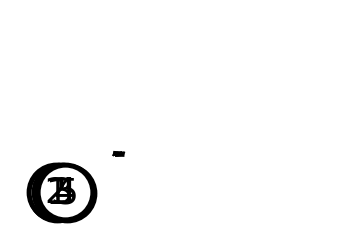

In [4]:
import networkx as nx

G = nx.Graph()
G.add_edge(1, 2)
G.add_edge(1, 3)
G.add_edge(1, 5)
G.add_edge(2, 3)
G.add_edge(3, 4)
G.add_edge(4, 5)


# explicitly set positions
pos = {1: (0, 0), 2: (-1, 0.3), 3: (2, 0.17), 4: (4, 0.255), 5: (5, 0.03)}

options = {
    "font_size": 36,
    "node_size": 3000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 5,
    "width": 5,
}
nx.draw_networkx(G, pos, **options)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

##### Attributes

In [5]:
G.number_of_nodes()
G.number_of_edges()
list(G.nodes)
list(G.edges)

G.degree(1, weight='weight')
Gsub=G.subgraph([2,3,4])

#### Directed Graph

For a DAG there are multiple ways.

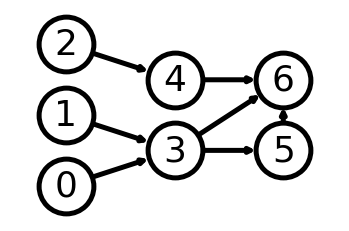

In [6]:
DG = nx.DiGraph([(0, 3), (1, 3), (2, 4), (3, 5), (3, 6), (4, 6), (5, 6)])

# group nodes by column
left_nodes = [0, 1, 2]
middle_nodes = [3, 4]
right_nodes = [5, 6]

# set the position according to column (x-coord)
pos = {n: (0, i) for i, n in enumerate(left_nodes)}
pos.update({n: (1, i + 0.5) for i, n in enumerate(middle_nodes)})
pos.update({n: (2, i + 0.5) for i, n in enumerate(right_nodes)})

nx.draw_networkx(DG, pos, **options)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

#### Graph components

In [7]:
DG.out_degree(3, weight='weight')
list(DG.nodes)
list(DG.edges)
DG.predecessors(6)
DG.successors(4)
nx.is_directed_acyclic_graph(DG)

# DG.ancestors([2,3])
# DG.descendants(c("b","e"),dag0)

True

### Operation on graphs

You can moralize a DAG and get an equivalent undirected graph.

In [8]:
mDG=nx.moral_graph(DG)

D-separation

In [9]:
nx.d_separated(DG, {5,6}, {1,0}, {3})

True

### Bayesian Networks

The term Bayesian network originates from Bayesian inference in expert systems.  Representing a joint probability distribution using a directed acyclic graph (a DAG) and exploiting the conditional independencies enable one to perform rapid and efficient computation of updated probabilities for states of unobserved variables.  Let's look at an example.

  Having flu (F) may cause elevated temperature (T). Elevated temperature may cause a headache (H).

This relationship can be written in probability notation as
$$p(FTH)=p(F)p(T|F)p(H|T)$$

This relationship can be expressed as a DAG in the following way

In [12]:
#plot((FTH<-dag(~ F + T:F + H:T)), "circo")

Now you have a headache, what is the probability of the flu $p(F=yes|H=yes)$ or you have a fever $p(T=yes|H=yes)$?

For this we need $p(F)$, $p(T|F)$, and $p(H|T)$.  We are going to pretend we know this information.

Unconditionally we will say that you get the flu with 1% probability.

In [13]:
DG2 = nx.DiGraph([("F", "T"), ("T","H")])
model = BayesianNetwork([('F', 'T'), ('T', 'H')])

cpd_f = TabularCPD(variable='F', variable_card=2, values=[[0.01], [0.99]])
print(cpd_f)

+------+------+
| F(0) | 0.01 |
+------+------+
| F(1) | 0.99 |
+------+------+


As for $p(T|F)$, we will say that given the flu, you will have a 95% probability of fever, but with no flu, you will have a 0.1% fever.

In [14]:
cpd_t = TabularCPD(variable='T', variable_card=2,
                   values=[[0.95, 0.001],
                           [0.05, 0.999,],],
                  evidence=['F'],
                  evidence_card=[2])
print(cpd_t)

+------+------+-------+
| F    | F(0) | F(1)  |
+------+------+-------+
| T(0) | 0.95 | 0.001 |
+------+------+-------+
| T(1) | 0.05 | 0.999 |
+------+------+-------+


As for $p(H|T)$, we will say that given a fever, you will have an 80% probability of headache, and with out a fever 1% probability of headache.

In [15]:
cpd_h = TabularCPD(variable='H', variable_card=2,
                   values=[[0.80, 0.010],
                           [0.20, 0.990,],],
                  evidence=['T'],
                  evidence_card=[2])
print(cpd_h)

+------+------+------+
| T    | T(0) | T(1) |
+------+------+------+
| H(0) | 0.8  | 0.01 |
+------+------+------+
| H(1) | 0.2  | 0.99 |
+------+------+------+


We can get the joint probability of flu and fever $p(FT)=p(T|F)p(F)$

In [16]:
model.add_cpds(cpd_f, cpd_t, cpd_h)
from pgmpy.inference import VariableElimination
model_infer = VariableElimination(model)
print(model_infer.query(["T","F"]))

+------+------+------------+
| T    | F    |   phi(T,F) |
+======+======+============+
| T(0) | F(0) |     0.0095 |
+------+------+------------+
| T(0) | F(1) |     0.0010 |
+------+------+------------+
| T(1) | F(0) |     0.0005 |
+------+------+------------+
| T(1) | F(1) |     0.9890 |
+------+------+------------+


and flu, fever, and headache $p(FTH)=p(H|T)p(FT)$

In [17]:
print(model_infer.query(["T","F","H"]))

+------+------+------+--------------+
| T    | F    | H    |   phi(T,F,H) |
+======+======+======+==============+
| T(0) | F(0) | H(0) |       0.0076 |
+------+------+------+--------------+
| T(0) | F(0) | H(1) |       0.0019 |
+------+------+------+--------------+
| T(0) | F(1) | H(0) |       0.0008 |
+------+------+------+--------------+
| T(0) | F(1) | H(1) |       0.0002 |
+------+------+------+--------------+
| T(1) | F(0) | H(0) |       0.0000 |
+------+------+------+--------------+
| T(1) | F(0) | H(1) |       0.0005 |
+------+------+------+--------------+
| T(1) | F(1) | H(0) |       0.0099 |
+------+------+------+--------------+
| T(1) | F(1) | H(1) |       0.9791 |
+------+------+------+--------------+


To calculate $p(F|H)$ we need $p(FH)$ and $p(H)$.
For this we marginalize $p(FTH)$ wrt $T$ so that $p(FH)=\sum_T p(FTH)$

In [18]:
model_hf=model_infer.query(['H','F'])
print(model_hf)

+------+------+------------+
| H    | F    |   phi(H,F) |
+======+======+============+
| H(0) | F(0) |     0.0076 |
+------+------+------------+
| H(0) | F(1) |     0.0107 |
+------+------+------------+
| H(1) | F(0) |     0.0024 |
+------+------+------------+
| H(1) | F(1) |     0.9793 |
+------+------+------------+


In [19]:
model_h=model_infer.query(['H'])
print(model_h)

+------+----------+
| H    |   phi(H) |
+======+==========+
| H(0) |   0.0183 |
+------+----------+
| H(1) |   0.9817 |
+------+----------+


From there, we can calculate the conditional probability
$$p(F|H)=\frac{p(FH)}{p(H)}=\frac{p(H|F)p(F)}{p(H)}$$

In [20]:
print(model_hf/model_h)

+------+------+------------+
| H    | F    |   phi(H,F) |
+======+======+============+
| H(0) | F(0) |     0.4159 |
+------+------+------------+
| H(0) | F(1) |     0.5841 |
+------+------+------------+
| H(1) | F(0) |     0.0024 |
+------+------+------------+
| H(1) | F(1) |     0.9976 |
+------+------+------------+


$p(Flu=\mbox{yes} | Headache=\mbox{yes})=0.42$

### Bayesian networks using the gRain package

The chest clinic example from Lauritzen and Spiegelhalter (1988).

In [ ]:
Chest_model= BayesianNetwork([('asia','tub'),('smoke','lung'),('smoke','bronc'),('lung','either'),('tub','either'),
('either','xray'),('bronc','dysp'),('either','dysp')])


# pgmpy
# g<-list(~asia,
#         ~tub    | asia,
#         ~smoke,
#         ~lung   | smoke,
#         ~bronc  | smoke,
#         ~either | lung : tub,
#         ~xray   | either,
#         ~dysp   | bronc : either)
# chestdag <- gRbase::dagList(g)

DAGs can be plotted nicely as

In [ ]:
import networkx as nx
import pylab as plt
nx_graph = nx.DiGraph(Chest_model.edges())
nx.draw(nx_graph, with_labels=True)
plt.show()

The moralized graph

In [ ]:
mDG_chest=nx.moral_graph(nx_graph)
nx.draw(mDG_chest, with_labels=True)
plt.show()

Checking for d-separation.

In [ ]:
nx.d_separated(nx_graph, {"tub"}, { "smoke"}, {"dysp","xray"})
nx.d_separated(nx_graph, {"tub"}, { "lung"}, {"smoke"})

Learning the parameters from the data given the model.

In [ ]:
from pgmpy.estimators import MaximumLikelihoodEstimator
data = pd.DataFrame(np.random.randint(low=0, high=2, size=(1000, 8)),
                      columns=['asia', 'tub', 'either', 'smoke', 'lung', 'bronc', 'dysp', 'xray'])
Chest_model.fit(data)
Chest_model.get_cpds()

Before observing any evidence

In [ ]:
inference = VariableElimination(Chest_model)
res_pre=inference.query(["tub","lung","bronc"],joint=False)
print(res_pre["bronc"])
print(res_pre["lung"])
print(res_pre["tub"])

If you have shortness of breath and if you went to "Asia".

In [ ]:
res=inference.query(["tub","lung","bronc"],evidence={'asia': 1, 'dysp': 1},joint=False)
print(res["bronc"])
print(res["lung"])
print(res["tub"])

After seeing x-ray is yes

In [ ]:
res_3=inference.query(["tub","lung","bronc"],evidence={'asia': 1, 'dysp': 1, "xray":1 },joint=False)
print(res_3["bronc"])
print(res_3["lung"])
print(res_3["tub"])

You can also get the joint probability.

In [ ]:
res_4=inference.query(["lung","bronc"],evidence={'asia': 1, 'dysp': 1, "xray":1 },joint=True)
print(res_4)

### Learning the network structure

Graph structure estimation is a hot topic we will not be able to cover we will just look at few examples.

### Hill-climbing algorithm

hc function in the bnlearn package implements hill-climbing algorithm to select a graphical model.  It uses greedy search to optimize a score, such as the BIC. This means that the current DAG is compared to all DAGs obtained by adding an edge, removing an edge, or reversing the direction of an edge. The model with the optimal score is chosen, and the process repeats until no score improvement can be made.

In [ ]:
from pgmpy.estimators import HillClimbSearch, BicScore
est = HillClimbSearch(data)
best_model = est.estimate(scoring_method=BicScore(data))
best_model.edges()
est.estimate(max_indegree=1).edges()

### A Hybrid Algorithm.

The max-min hill-climbing algorithm is a hybrid constraint/score-based algorithm implemented as mmhc function.

In [ ]:
from pgmpy.estimators import MmhcEstimator
est = MmhcEstimator(data)
model = est.estimate()
print(model.edges())

### Gaussian Graphical model example

Sample correlation are misleading.  Here is one illustration of why.
We will generate from multivariate Gaussian distribution.

In [ ]:
from numpy.linalg import inv
#http://people.math.aau.dk/~sorenh/misc/2016-gmbn-rennes/doc/bayesnet-slides.pdf
K= [[2.,1.,0.],
              [1.,2.,1.],
              [0.,1.,2.]]
K

K is the TRUE inverse covariance matrix or the precision matrix where Zero in the matrices implies independence.

But when you take an inverse of the precision matrix, what you get is

In [ ]:
Sigma = inv(K)
Sigma

You generate data from MVN using this variance-covariance matrix and you get

In [ ]:
mean = [0, 0]
d = np.random.multivariate_normal([0,0,0], Sigma, 5000)

In [ ]:
dx=pd.DataFrame(d,columns=['x1', 'x2', 'x3'])
dx.corr()

Both plot and correlation suggest a mild correlation between 1 and 3, and they are both correlated with 2.

Let's look at the partial correlation by regressing out the effect of 2 from both 1 and 3.

In [ ]:
import statsmodels.api as sm
y=dx["x1"]
x=dx["x2"]
mod12 = sm.OLS(dx["x1"],  sm.add_constant(dx["x2"]))
res12 = mod12.fit().resid

mod32 = sm.OLS(dx["x3"], sm.add_constant( dx["x2"]))
res32 = mod32.fit().resid
plt.scatter(res12, res32)
plt.show()

The correlation disappeared

In [ ]:
dxres=pd.DataFrame({'res12':res12, 'res32':res32})
dxres.corr()

You can do the same using regression.

In [ ]:
mod123=sm.OLS(dx["x1"], sm.add_constant(dx[["x2","x3"]]))
res123 = mod123.fit()
res123.params

The bottom line is that correlation is a dangerous thing to look too much into; if possible, one should look at partial correlation.

### Causal DAG

Another package, `causaldag`

In [ ]:
#pip3 install causaldag
import causaldag as cd
dag = cd.DAG(arcs={(1, 2), (2, 3), (1, 3)})
cpdag = dag.cpdag()
dag.reversible_arcs()